In [2]:
import scanpy as sc
import torch
import anndata
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
import pandas as pd
import scvi

In [3]:
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [3]:
adata = sc.read_csv(r"C:\Users\liamm\Desktop\New folder\GSE138852_counts.csv").T
#Transpose for cells x genes, adata format

In [5]:
adata

AnnData object with n_obs × n_vars = 13214 × 10850

In [6]:
adata.obs.head()

""
AAACCTGGTAGAAAGG_AD5_AD6
AAACCTGGTAGCGATG_AD5_AD6
AAACCTGTCAGTCAGT_AD5_AD6
AAACCTGTCCAAACAC_AD5_AD6
AAACCTGTCCAGTATG_AD5_AD6


In [7]:
adata.var.head()

""
FO538757.2
AP006222.2
RP5-857K21.4
RP11-206L10.9
NOC2L


In [8]:
sc.pp.filter_genes(adata, min_cells = 10) #Keep genes that are found in at least 10 cells 

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3') #Filter for most variable genes

In [10]:
adata

AnnData object with n_obs × n_vars = 13214 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [12]:
import torch

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Device count:", torch.cuda.device_count())
else:
    print("CUDA is NOT available.")

CUDA available: True
CUDA version: 12.1
cuDNN version: 90100
GPU name: NVIDIA GeForce RTX 2070 SUPER
Device count: 1


In [11]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train() #Variational autoencoder builds a probabilistic model of gene expression (latent representation)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [13]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train() #Train to distinguish doublets 

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.173. Signaling Trainer to stop.


In [14]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACCTGGTAGAAAGG_AD5_A,0.046560,0.953440,singlet
AAACCTGGTAGCGATG_AD5_A,0.247673,0.752327,singlet
AAACCTGTCAGTCAGT_AD5_A,0.079157,0.920843,singlet
AAACCTGTCCAAACAC_AD5_A,0.164119,0.835881,singlet
AAACCTGTCCAGTATG_AD5_A,0.007581,0.992419,singlet
...,...,...,...
TTTGGTTTCCGTACAA_AD1_A,0.000058,0.999942,singlet
TTTGTCACAAGCCATT_AD1_A,0.009481,0.990519,singlet
TTTGTCAGTATAGGTA_AD1_A,0.000162,0.999838,singlet
TTTGTCATCCACTGGG_AD1_A,0.262832,0.737168,singlet


In [25]:
df.groupby('prediction').count()

,doublet,singlet,dif,final_doublet_call
prediction,,,,
doublet,1507,1507,1507,1507
singlet,11707,11707,11707,11707


In [26]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif,final_doublet_call
AAACCTGGTAGAAAGG_AD5_A,0.046560,0.953440,singlet,-0.906881,False
AAACCTGGTAGCGATG_AD5_A,0.247673,0.752327,singlet,-0.504654,False
AAACCTGTCAGTCAGT_AD5_A,0.079157,0.920843,singlet,-0.841686,False
AAACCTGTCCAAACAC_AD5_A,0.164119,0.835881,singlet,-0.671761,False
AAACCTGTCCAGTATG_AD5_A,0.007581,0.992419,singlet,-0.984838,False
...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_A,0.000058,0.999942,singlet,-0.999884,False
TTTGTCACAAGCCATT_AD1_A,0.009481,0.990519,singlet,-0.981039,False
TTTGTCAGTATAGGTA_AD1_A,0.000162,0.999838,singlet,-0.999677,False
TTTGTCATCCACTGGG_AD1_A,0.262832,0.737168,singlet,-0.474336,False


<Axes: xlabel='dif', ylabel='Count'>

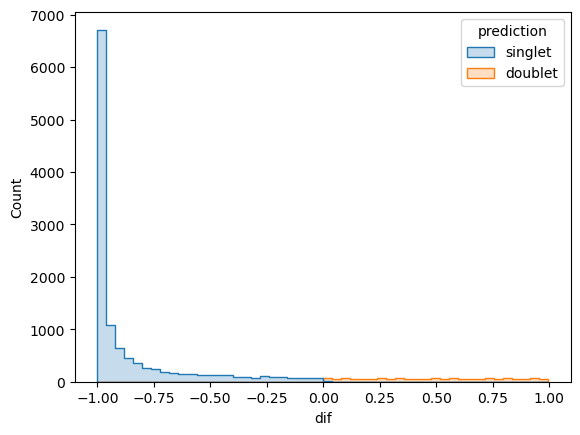

In [27]:
sns.histplot(df, x='dif', hue='prediction', bins=50, element='step')

In [28]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0)]
doublets

,doublet,singlet,prediction,dif,final_doublet_call
AACTCAGCACGAAGCA_AD5_A,0.553607,0.446393,doublet,0.107214,True
AAGACCTAGATCCTGT_AD5_A,0.605835,0.394165,doublet,0.211670,True
AAGACCTTCAAACCAC_AD5_A,0.626117,0.373883,doublet,0.252235,True
AAGGAGCCAAGTTAAG_AD5_A,0.944898,0.055102,doublet,0.889796,True
AAGGCAGAGACTTGAA_AD5_A,0.659698,0.340302,doublet,0.319396,True
...,...,...,...,...,...
TTGTAGGTCGTAGATC_AD1_A,0.554543,0.445457,doublet,0.109086,True
TTTATGCCACCAGGCT_AD1_A,0.691068,0.308932,doublet,0.382137,True
TTTCCTCGTGGCAAAC_AD1_A,0.853700,0.146300,doublet,0.707400,True
TTTGCGCAGGAGTTTA_AD1_A,0.508530,0.491470,doublet,0.017059,True


In [29]:
#1507 cells flagged as doublets 